# Notebook ICD - 21

### Llibraries

In [2]:
!pip install fastdtw

  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-macosx_11_0_arm64.whl size=88692 sha256=da6d6f895d5effb92cb0b3d7fa1b282598fa67eb77bbd722ea52b2a45efa5855
  Stored in directory: /Users/paco/Library/Caches/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.metrics import confusion_matrix, accuracy_score

### Dataset

In [6]:
def load_ecg_data(filename):
    """Load ECG200 time-series dataset from file."""
    data = np.loadtxt(filename)
    labels = data[:, 0]  # First column contains labels
    series = data[:, 1:]  # Remaining columns contain time-series data
    return series, labels

train_data, train_labels = load_ecg_data("ECG200_TRAIN.txt")
test_data, test_labels = load_ecg_data("ECG200_TEST.txt")

### Exploratory analysis

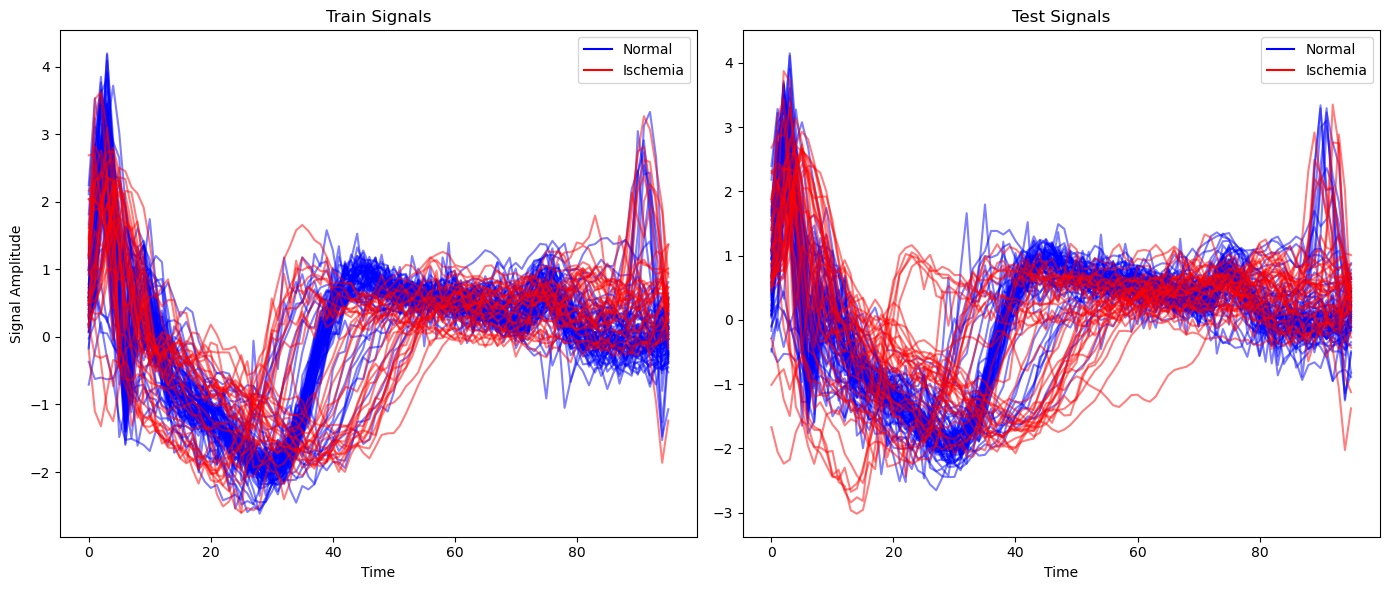

In [8]:
# Separate normal and ischemia signals
train_normal_signals = train_data[train_labels == 1]
train_ischemia_signals = train_data[train_labels == -1]
test_normal_signals = test_data[test_labels == 1]
test_ischemia_signals = test_data[test_labels == -1]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot train signals
for signal in train_normal_signals:
    axs[0].plot(signal, color='blue', alpha=0.5)  # Normal in blue
for signal in train_ischemia_signals:
    axs[0].plot(signal, color='red', alpha=0.5)   # Ischemia in red
axs[0].set_title("Train Signals")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Signal Amplitude")
axs[0].plot([], [], color='blue', label='Normal')   # Legend for Normal
axs[0].plot([], [], color='red', label='Ischemia')  # Legend for Ischemia
axs[0].legend(loc="upper right")

# Plot test signals
for signal in test_normal_signals:
    axs[1].plot(signal, color='blue', alpha=0.5)  # Normal in blue
for signal in test_ischemia_signals:
    axs[1].plot(signal, color='red', alpha=0.5)   # Ischemia in red
axs[1].set_title("Test Signals")
axs[1].set_xlabel("Time")
axs[1].plot([], [], color='blue', label='Normal')   # Legend for Normal
axs[1].plot([], [], color='red', label='Ischemia')  # Legend for Ischemia
axs[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

### DTW implementation

In [10]:
def dtw_distance(ts1, ts2):
    distance, _ = fastdtw(ts1, ts2)
    return distance

In [12]:
# Inference step, remember there is not fitting step alone
def classify_with_dtw(new_example, templates):
    # Flatten new_example to ensure it's 1-D
    new_example = np.array(new_example).reshape(-1)  # Flatten to 1-D if not already
    distances = {label: [] for label in templates.keys()}
    
    # Compute DTW distances to each template
    for label, template_list in templates.items():
        for template in template_list:
            # Flatten template to ensure it's 1-D
            template = np.array(template).reshape(-1)

            distance = dtw_distance(new_example, template)
            distances[label].append(distance)
    
    # Average distances per class
    avg_distances = {label: round(np.mean(distances[label]), 3) for label in distances}
    
    predicted_class = min(avg_distances, key=avg_distances.get)
    
    return predicted_class, avg_distances

### Selecting data

In [38]:
# Randomly select n instances (for each class) to be used as templates
num_templates = 50
templates = {label: train_data[train_labels == label][:num_templates] for label in np.unique(train_labels)}

In [40]:
# Randomly select n instances from the test set
num_instances = 5
random_indices = np.random.choice(test_data.shape[0], size=num_instances, replace=False)  # Ensure no replacement
selected_samples = test_data[random_indices]
selected_labels = test_labels[random_indices]

Avg DTW Distances to Each Class: {-1.0: 29.693, 1.0: 21.207}
Predicted Class: 1.0
Actual Class: 1.0


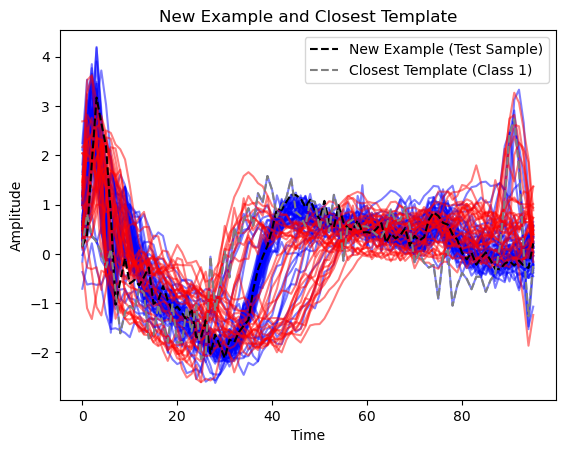

Avg DTW Distances to Each Class: {-1.0: 20.84, 1.0: 27.014}
Predicted Class: -1.0
Actual Class: -1.0


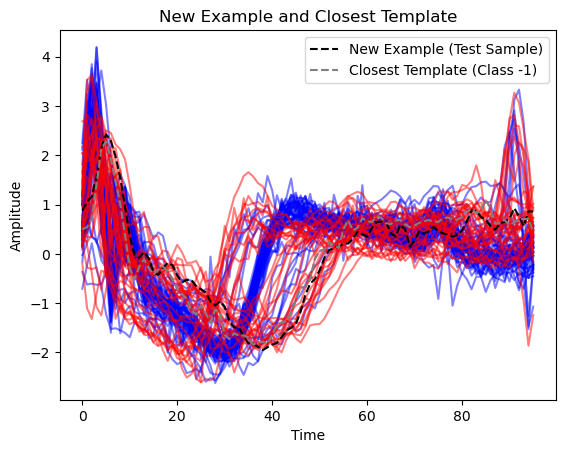

Avg DTW Distances to Each Class: {-1.0: 28.168, 1.0: 19.493}
Predicted Class: 1.0
Actual Class: 1.0


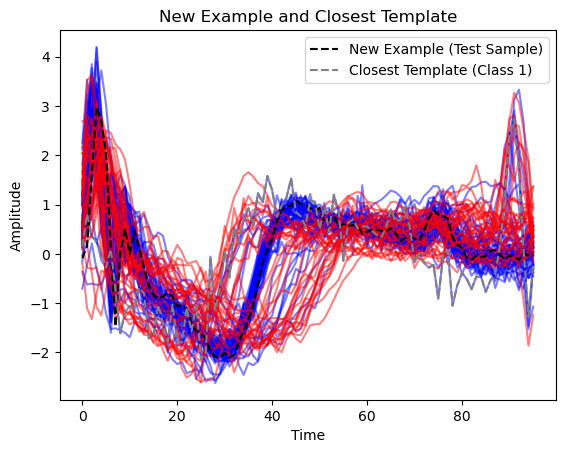

Avg DTW Distances to Each Class: {-1.0: 25.361, 1.0: 21.1}
Predicted Class: 1.0
Actual Class: 1.0


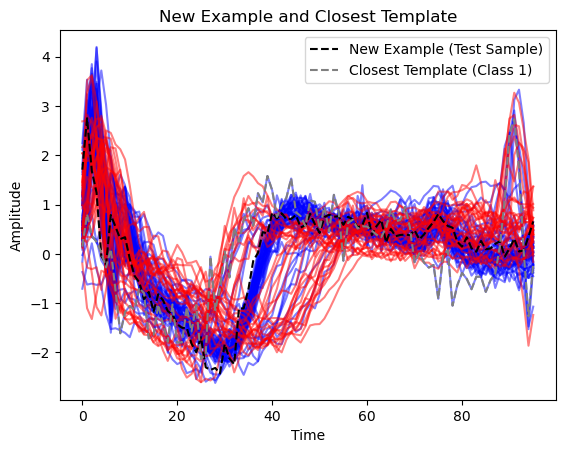

Avg DTW Distances to Each Class: {-1.0: 34.107, 1.0: 30.993}
Predicted Class: 1.0
Actual Class: 1.0


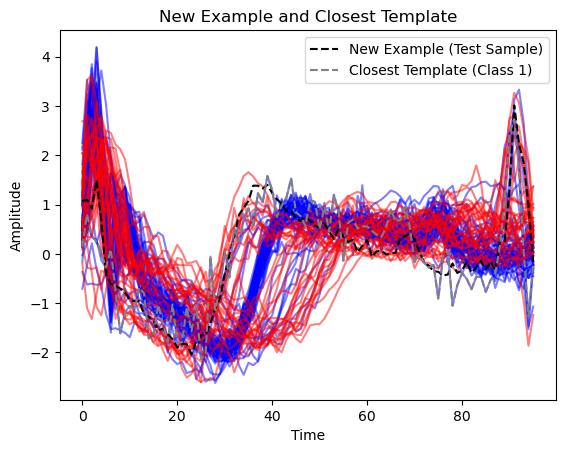

In [42]:
# Initialize lists to store predicted classes and average distances
predicted_classes = []
average_distances = []

# Test classification on each randomly selected sample
for new_example, actual_label in zip(selected_samples, selected_labels):

    predicted_class, avg_distance = classify_with_dtw(new_example, templates)
    predicted_classes.append(predicted_class)
    average_distances.append(avg_distance)
    
    # Display Results
    print("Avg DTW Distances to Each Class:", avg_distance)
    print("Predicted Class:", predicted_class)
    print("Actual Class:", actual_label)
    
    # Separate normal and ischemia signals
    templates_normal_signals = templates[1]   # Access templates for normal signals (label == 1)
    templates_ischemia_signals = templates[-1]  # Access templates for ischemia signals (label == -1)

    # Plot all training signals
    for signal in templates_normal_signals:
        plt.plot(signal, color='blue', alpha=0.5)  # Normal in blue
    for signal in templates_ischemia_signals:
        plt.plot(signal, color='red', alpha=0.5)   # Ischemia in red

    # Visualize New Example with Closest Template from Predicted Class
    plt.plot(new_example, label='New Example (Test Sample)', color='black', linestyle='--')
    closest_template = templates[predicted_class][0]
    plt.plot(closest_template, label=f'Closest Template (Class {int(predicted_class)})', color='grey', linestyle='--')
    plt.legend()
    plt.title('New Example and Closest Template')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

[ 1. -1.  1.  1.  1.]
[ 1. -1.  1.  1.  1.]
Accuracy: 1.00


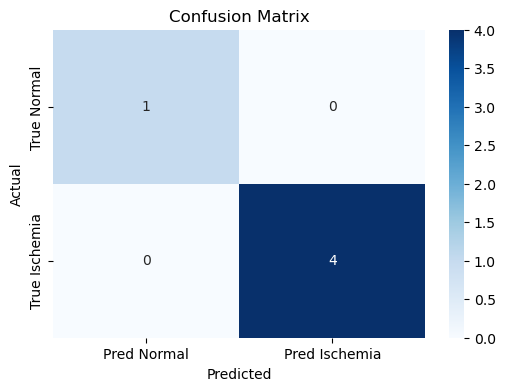

In [44]:
# Convert predicted classes to a NumPy array for easier manipulation
predicted_classes = np.array(predicted_classes)
print(predicted_classes)
print(selected_labels)

# Generate confusion matrix
cm = confusion_matrix(selected_labels, predicted_classes)

# Calculate accuracy
accuracy = accuracy_score(selected_labels, predicted_classes)

# Print accuracy
print(f"Accuracy: {accuracy:.2f}")

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Normal', 'Pred Ischemia'], yticklabels=['True Normal', 'True Ischemia'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()